**Further train DeepCell Models with K's Data and Make Predictions**<br>
The model has three heads: inner distance, outer distance, and fgbg. It works on tensorflow 2.7.1.<br>
We first train a model with nucleus data from the Tissuenet V1.0 dataset and save the model. <br>
We then further train the model with 28 square images of size 512x512 from training_512x512. There are 50193 training instances in total.

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
model_path = 'tn1.0_nuclear_K.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
epochs=60 # 7 sec per epoch
label="nuclear_K"

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os

import deepcell
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell import image_generators

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [3]:
import glob
INPUT_PATH="images/training_512x512/"
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))

28


In [4]:
imgs = [io.imread(CURR_IM_NAME)[:,:,0] for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

# np.savez("K_training_data", X=X_train, y=y_train) # objects to save need to be key value pairs
# train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

2022-11-02 18:35:56.430207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 375 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-02 18:35:56.431596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14208 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-02 18:35:56.432794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14208 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


(28, 512, 512, 1)
(28, 512, 512, 1)


In [5]:
seed=0
min_objects = 2

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

50193


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


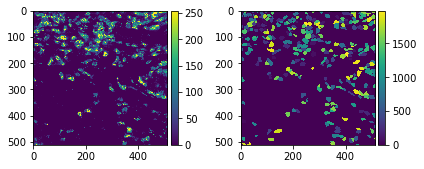

In [6]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [7]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-11-02 16:31:47.070977: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [8]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-02 15:44:04.182527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-02 15:44:04.183435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-02 15:44:04.184351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/60


2022-11-02 15:44:19.931173: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


7/7 [==============================] - 27s 925ms/step - loss: 0.0242 - semantic_0_loss: 0.0094 - semantic_1_loss: 0.0123 - semantic_2_loss: 0.0024 - lr: 1.0000e-04
Epoch 2/60
7/7 [==============================] - 7s 995ms/step - loss: 0.0209 - semantic_0_loss: 0.0083 - semantic_1_loss: 0.0108 - semantic_2_loss: 0.0018 - lr: 9.9000e-05
Epoch 3/60
7/7 [==============================] - 7s 1s/step - loss: 0.0200 - semantic_0_loss: 0.0080 - semantic_1_loss: 0.0103 - semantic_2_loss: 0.0017 - lr: 9.8010e-05
Epoch 4/60
7/7 [==============================] - 7s 1s/step - loss: 0.0199 - semantic_0_loss: 0.0079 - semantic_1_loss: 0.0103 - semantic_2_loss: 0.0017 - lr: 9.7030e-05
Epoch 5/60
7/7 [==============================] - 7s 971ms/step - loss: 0.0198 - semantic_0_loss: 0.0078 - semantic_1_loss: 0.0103 - semantic_2_loss: 0.0017 - lr: 9.6060e-05
Epoch 6/60
7/7 [==============================] - 7s 985ms/step - loss: 0.0194 - semantic_0_loss: 0.0077 - semantic_1_loss: 0.0100 - semantic_2_lo

Epoch 22/60
7/7 [==============================] - 7s 1s/step - loss: 0.0188 - semantic_0_loss: 0.0075 - semantic_1_loss: 0.0097 - semantic_2_loss: 0.0016 - lr: 8.0973e-05
Epoch 23/60
7/7 [==============================] - 7s 936ms/step - loss: 0.0183 - semantic_0_loss: 0.0073 - semantic_1_loss: 0.0095 - semantic_2_loss: 0.0015 - lr: 8.0163e-05
Epoch 24/60
7/7 [==============================] - 8s 955ms/step - loss: 0.0187 - semantic_0_loss: 0.0075 - semantic_1_loss: 0.0096 - semantic_2_loss: 0.0016 - lr: 7.9361e-05
Epoch 25/60
7/7 [==============================] - 7s 1000ms/step - loss: 0.0180 - semantic_0_loss: 0.0072 - semantic_1_loss: 0.0093 - semantic_2_loss: 0.0015 - lr: 7.8568e-05
Epoch 26/60
7/7 [==============================] - 7s 1s/step - loss: 0.0179 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0093 - semantic_2_loss: 0.0015 - lr: 7.7782e-05
Epoch 27/60
7/7 [==============================] - 7s 995ms/step - loss: 0.0184 - semantic_0_loss: 0.0073 - semantic_1_loss: 0.009

Epoch 43/60
7/7 [==============================] - 7s 1s/step - loss: 0.0179 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0092 - semantic_2_loss: 0.0015 - lr: 6.5566e-05
Epoch 44/60
7/7 [==============================] - 7s 939ms/step - loss: 0.0177 - semantic_0_loss: 0.0070 - semantic_1_loss: 0.0092 - semantic_2_loss: 0.0015 - lr: 6.4910e-05
Epoch 45/60
7/7 [==============================] - 8s 1s/step - loss: 0.0178 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0092 - semantic_2_loss: 0.0015 - lr: 6.4261e-05
Epoch 46/60
7/7 [==============================] - 7s 988ms/step - loss: 0.0178 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0092 - semantic_2_loss: 0.0015 - lr: 6.3619e-05
Epoch 47/60
7/7 [==============================] - 7s 943ms/step - loss: 0.0177 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0091 - semantic_2_loss: 0.0015 - lr: 6.2982e-05
Epoch 48/60
7/7 [==============================] - 7s 985ms/step - loss: 0.0176 - semantic_0_loss: 0.0071 - semantic_1_loss: 0.0091

/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


<B>Make predictions on Nuclear test dataset.</B> 

In [10]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= X_train.shape[1:]
)

prediction_model.load_weights(model_path, by_name=True)

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [17]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [18]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [19]:
APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=1)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.3086232980332829, 'M872956_JML_Position10_CD3_test_img.png': 0.3577371048252912, 'M872956_JML_Position8_CD8_test_img.png': 0.36363636363636365, 'M926910_CFL_Position13_CD3_test_img.png': 0.2064516129032258, 'M872956_JML_Position8_CD3_test_img.png': 0.3940345368916798, 'M872956_JML_P

In [20]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_tn_'+label+'.txt', index=False, header=False)

                                         0         1
0   M926910_CFL_Position7_CD3_test_img.png  0.308623
1  M872956_JML_Position10_CD3_test_img.png  0.357737
2   M872956_JML_Position8_CD8_test_img.png  0.363636
3  M926910_CFL_Position13_CD3_test_img.png  0.206452
4   M872956_JML_Position8_CD3_test_img.png  0.394035
5   M872956_JML_Position8_CD4_test_img.png  0.420945
6   M872956_JML_Position9_CD3_test_img.png  0.337058
7                                      mAP  0.341212


**mAP**<br>
image_mpp default: .<br>
image_mpp=1: .34<br>
image_mpp=2: .<br>